### Importação e Configuração

Importando bibliotecas

In [23]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Função para processar cada imagem da pasta

In [24]:
def carregar_e_processar_imagem(caminho_imagem, largura, altura): 
    image = cv2.imread(caminho_imagem)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imagem_redimensionada = cv2.resize(image_rgb, (largura, altura))
    imagem_normalizada = imagem_redimensionada #/ 255.0
    return imagem_normalizada

Definição de Constantes

In [25]:
CAMINHO_PASTA = '../data/chihuahua-muffin' # pasta com imagens
print(CAMINHO_PASTA)
LARGURA, ALTURA = 170, 170 # dimensão das imagens

ROTULO_MUFFIN = 0
ROTULO_CHIHUAHUA = 1

BATCH_SIZE = 1

../data/chihuahua-muffin


### Pré-Processamento de imagens

Instância do Gerador de Imagens para o Aumento do DataSet

In [26]:
def gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

datagen = ImageDataGenerator(   # configurações do DataGenerator
    preprocessing_function=gaussian_filter, # Aplica filtro gausseano
    brightness_range=(0.2,0.4), # Faixa de filtro do efeito de aumento de brilho 0 - 100%
    rotation_range=20,          # Grau de rotação aleatória no sentido anti-horário, variando de 0 a 40 graus.
    width_shift_range=0.2,      # Faixa de deslocamento horizontal aleatório, variando de -20% a 20% da largura da imagem.
    height_shift_range=0.2,     # Faixa de deslocamento vertical aleatório, variando de -20% a 20% da altura da imagem.
    shear_range=0.15,            # Intensidade de cisalhamento aleatório.
    zoom_range=0.25,             # Intervalo para aplicar zoom aleatório. Um valor de 0.2 significa zoom de 80% a 120%.
    horizontal_flip=True,       # Possibilidade de inverter horizontalmente a imagem aleatoriamente.
    fill_mode='nearest'         # Estratégia de preenchimento para pixels criados durante transformações. 'nearest' preenche com o valor mais próximo.
)

Listando imagens do DataSet

In [27]:
data_file_path = os.listdir(CAMINHO_PASTA)
data_file_path

['chihuahua-1.jpg',
 'chihuahua-2.jpg',
 'chihuahua-3.jpg',
 'chihuahua-4.jpg',
 'chihuahua-5.jpg',
 'chihuahua-6.jpg',
 'chihuahua-7.jpg',
 'chihuahua-8.jpg',
 'muffin-1.jpeg',
 'muffin-2.jpeg',
 'muffin-3.jpeg',
 'muffin-4.jpeg',
 'muffin-5.jpeg',
 'muffin-6.jpeg',
 'muffin-7.jpeg',
 'muffin-8.jpeg']

Pre processamento das imagens (Alteração de cor, redimensionamento, definição de rótulo, aumento de dados)

In [28]:
imagens_pre_processadas = [] # arrays para pre_processamento[]
rotulos = []


for arquivo in data_file_path:
    
    caminho_imagem = os.path.join(CAMINHO_PASTA, arquivo) # busca o caminho da imagem
    imagem_carregada = carregar_e_processar_imagem(caminho_imagem, LARGURA, ALTURA)
    imagens_pre_processadas.append(imagem_carregada)

    if "muffin" in arquivo:
        rotulos.append(ROTULO_MUFFIN)
    elif "chihuahua" in arquivo:
        rotulos.append(ROTULO_CHIHUAHUA)

#array numpy
imagens_array = np.array(imagens_pre_processadas)
rotulos_array = np.array(rotulos)

Visualizando uma imagem pré-processada

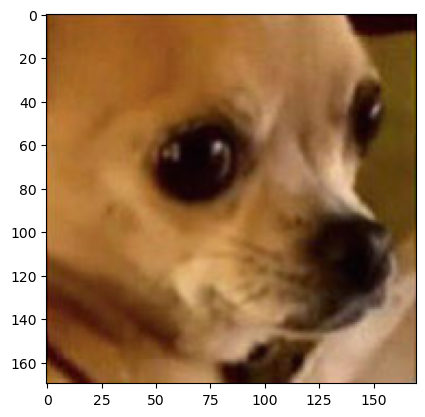

In [29]:
plt.imshow(imagens_pre_processadas[0])

Gerando aumento de dados nas imagens existentes

In [30]:
imagens_aumentadas = []

for imgprocessada in imagens_pre_processadas:  # aumento de Dados
    img = np.expand_dims(imgprocessada, 0)
    augmented_img = next(datagen.flow(img))[0].astype(np.uint8)
    augmented_img = augmented_img / 255.0
    imagens_aumentadas.append(augmented_img)

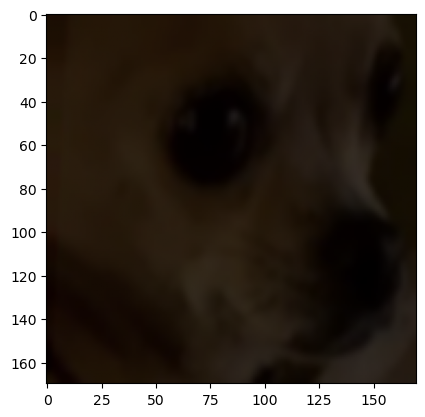

In [31]:
plt.imshow(imagens_aumentadas[0])

Verificando proporção de Rotulos e Imagens

In [32]:
print(len(imagens_pre_processadas))
print(len(rotulos))
assert len(imagens_pre_processadas) == len(rotulos), "Número inconsistente de imagens e rótulos."

16
16


Dividir os dados em conjuntos de treinamento e teste

In [33]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split( # X = imagens Y = rotulos/classes
    imagens_array, rotulos_array, test_size=0.3, random_state=42 # separa as imagens em 20% para teste e 80% para treino.
)

print(len(X_treino), len(X_teste), len(Y_treino), len(Y_teste))

11 5 11 5


Criando os geradores de imagem para o aumento de dados

In [34]:
datagen.fit(X_treino)
test_generator  = datagen.flow(X_teste, Y_teste, batch_size=BATCH_SIZE)
train_generator = datagen.flow(X_treino, Y_treino, batch_size=BATCH_SIZE)

### Criação e Treinamento do modelo

Configurando o Modelo

In [35]:
modelo = models.Sequential() # cria modelo sequencial e adiciona os modulos
modelo.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(LARGURA, ALTURA, 3)))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(layers.Conv2D(128, (3, 3), activation='relu'))
modelo.add(layers.MaxPooling2D((2, 2)))
modelo.add(layers.Flatten())
modelo.add(layers.Dense(128, activation='relu'))
modelo.add(layers.Dense(1, activation='sigmoid'))

c:\Users\Felipe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Compilando modelo

In [36]:
modelo.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy']
               ) 

Treinando modelo

In [37]:
history = modelo.fit(train_generator, 
                    # steps_per_epoch = train_generator.n//batch_size,
                     epochs=30, 
                     validation_data=(test_generator), 
                    # validation_steps=test_generator.n//batch_size
                     ) # treinar o modelo

Epoch 1/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0000e+00 - loss: 15.0250

c:\Users\Felipe\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5558 - loss: 138.8071 - val_accuracy: 0.6000 - val_loss: 46.4134
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6631 - loss: 9.7683 - val_accuracy: 0.4000 - val_loss: 12.3410
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6409 - loss: 7.9949 - val_accuracy: 0.4000 - val_loss: 5.9571
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6459 - loss: 4.5224 - val_accuracy: 0.6000 - val_loss: 1.5181
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6070 - loss: 1.3326 - val_accuracy: 0.4000 - val_loss: 1.6933
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8506 - loss: 0.2286 - val_accuracy: 0.6000 - val_loss: 0.6356
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9848 - loss: 0.1696 - val_accuracy: 0.6000 - val_loss: 1.0185
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6445 - loss: 0.7866 - val_accuracy: 0.6000 - val_loss

Visualizando histórico de acurácia em treinamento

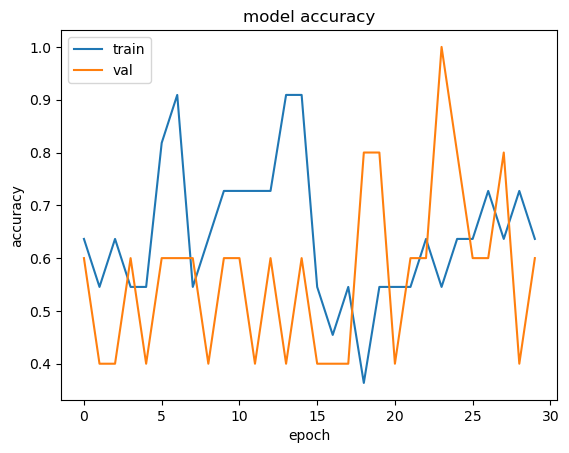

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Visualizando histórico de perda em treinamento

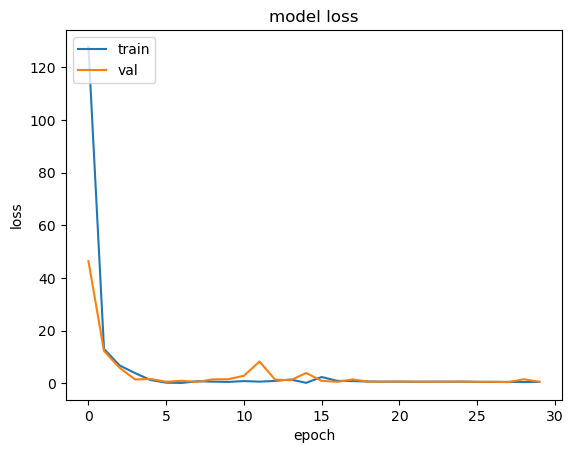

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Gerando mapa de calor(Real vs Predito)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


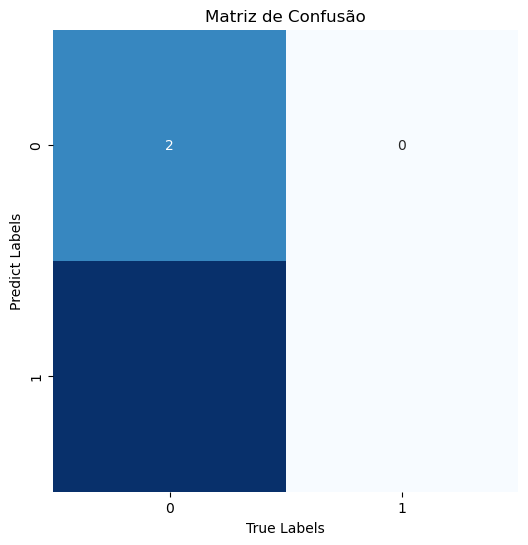

In [40]:
predictions = modelo.predict(test_generator)

ypred = np.argmax(predictions, axis=1)
true_labels = Y_teste

conf_matrix = confusion_matrix(true_labels, ypred)

plt.figure(figsize = (6,6))

sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.xlabel('True Labels')
plt.ylabel('Predict Labels')
plt.title('Matriz de Confusão')
plt.show()


### Predição do Modelo

Definindo caminho dos arquivos de predição

In [41]:
caminho_input = '../data/imagens-para-classificar'
input_file_path = os.listdir(caminho_input)
input_file_path

['chihuahua-2-x.jpg', 'chihuahua-x.jpg', 'muffin-1-x.jpg', 'muffin-2-x.jpg']

Executando a predição

In [42]:
for img_input in input_file_path:
    caminho_nova_imagem = os.path.join(caminho_input, img_input)
    nova_imagem = carregar_e_processar_imagem(caminho_nova_imagem, LARGURA, ALTURA)
    nova_imagem = np.expand_dims(nova_imagem, axis=0)
    previsao = modelo.predict(nova_imagem)
    classe_predita = "muffin" if previsao[0][0] < 0.5 else "chihuahua"
    print(previsao)

    print(img_input)
    print(f"A imagem é classificada como: {classe_predita}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[[0.9999997]]
chihuahua-2-x.jpg
A imagem é classificada como: chihuahua
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.44297957]]
chihuahua-x.jpg
A imagem é classificada como: muffin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.6564872]]
muffin-1-x.jpg
A imagem é classificada como: chihuahua
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.1334568]]
muffin-2-x.jpg
A imagem é classificada como: muffin
